In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [2]:
bjets_DF = pd.read_pickle("./bjets.pkl")
cjets_DF = pd.read_pickle("./cjets.pkl")
ljets_DF = pd.read_pickle("./ljets.pkl")

Extract the track parameters as our features

In [3]:
%%time
trks=np.zeros((len(bjets_DF), 30, 5))

for i in range(len(bjets_DF)):
    trks[i] = np.array([bjets_DF['tracks'][i]])[:,:,0:5]
    


Wall time: 9.55 s


In [4]:
X = trks # following convention name the features as the vector 'X'

And the secondary and tertiary vertices as our labels

In [5]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [6]:
X_train=X[:80000]
X_test=X[80000:]
y_train=y[:80000]
y_test=y[80000:]

In [7]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:80000]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[80000:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:80000]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[80000:]
plt.show()

0.0036985106615352826
0.007068593500451309


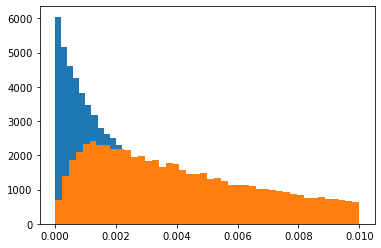

In [8]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


0.0036550417303922366
0.006973962985526242


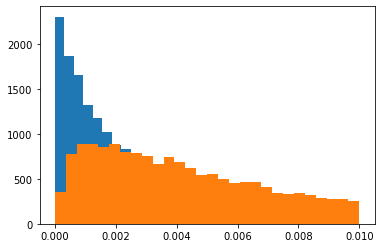

In [9]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [10]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 100
nDense = 20

In [11]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [12]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.8)(lstm)

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt)

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [13]:
myRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 30, 5)             0         
_________________________________________________________________
masking_1 (Masking)          (None, 30, 5)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 20)                2020      
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 126       
Total params: 44,546
Trainable params: 44,546
Non-trainable params: 0
_________________________________________________________________


In [14]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [15]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [16]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [17]:
nEpochs = 100

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.25,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

Train on 60000 samples, validate on 20000 samples
Epoch 1/100
60000/60000 [==============================] - 34s 563us/step - loss: 2.1380 - mean_absolute_error: 2.1380 - val_loss: 1.8461 - val_mean_absolute_error: 1.8461
Epoch 2/100
60000/60000 [==============================] - 29s 478us/step - loss: 1.9278 - mean_absolute_error: 1.9278 - val_loss: 1.8034 - val_mean_absolute_error: 1.8034
Epoch 3/100
60000/60000 [==============================] - 28s 472us/step - loss: 1.8925 - mean_absolute_error: 1.8925 - val_loss: 1.7963 - val_mean_absolute_error: 1.7963
Epoch 4/100
60000/60000 [==============================] - 33s 547us/step - loss: 1.8812 - mean_absolute_error: 1.8812 - val_loss: 1.7862 - val_mean_absolute_error: 1.7862
Epoch 5/100
60000/60000 [==============================] - 32s 529us/step - loss: 1.8678 - mean_absolute_error: 1.8678 - val_loss: 1.7779 - val_mean_absolute_error: 1.7779
Epoch 6/100
60000/60000 [==============================] - 33s 556us/step - loss: 1.8572 -

60000/60000 [==============================] - 19s 309us/step - loss: 1.6823 - mean_absolute_error: 1.6823 - val_loss: 1.5427 - val_mean_absolute_error: 1.5427
Epoch 25/100
60000/60000 [==============================] - 19s 317us/step - loss: 1.6321 - mean_absolute_error: 1.6321 - val_loss: 1.5203 - val_mean_absolute_error: 1.5203
Epoch 26/100
60000/60000 [==============================] - 19s 320us/step - loss: 1.5889 - mean_absolute_error: 1.5889 - val_loss: 1.4363 - val_mean_absolute_error: 1.4363
Epoch 27/100
60000/60000 [==============================] - 19s 315us/step - loss: 1.5600 - mean_absolute_error: 1.5600 - val_loss: 1.3884 - val_mean_absolute_error: 1.3884
Epoch 28/100
60000/60000 [==============================] - 20s 331us/step - loss: 1.5239 - mean_absolute_error: 1.5239 - val_loss: 1.3509 - val_mean_absolute_error: 1.3509
Epoch 29/100
60000/60000 [==============================] - 20s 341us/step - loss: 1.5035 - mean_absolute_error: 1.5035 - val_loss: 1.3639 - val_mea

Epoch 48/100
60000/60000 [==============================] - 23s 390us/step - loss: 1.3335 - mean_absolute_error: 1.3335 - val_loss: 1.1109 - val_mean_absolute_error: 1.1109
Epoch 49/100
60000/60000 [==============================] - 25s 410us/step - loss: 1.3269 - mean_absolute_error: 1.3269 - val_loss: 1.1496 - val_mean_absolute_error: 1.1496
Epoch 50/100
60000/60000 [==============================] - 25s 414us/step - loss: 1.3268 - mean_absolute_error: 1.3268 - val_loss: 1.0986 - val_mean_absolute_error: 1.0986
Epoch 51/100
60000/60000 [==============================] - 23s 388us/step - loss: 1.3191 - mean_absolute_error: 1.3191 - val_loss: 1.1098 - val_mean_absolute_error: 1.1098
Epoch 52/100
60000/60000 [==============================] - 21s 354us/step - loss: 1.3187 - mean_absolute_error: 1.3187 - val_loss: 1.0972 - val_mean_absolute_error: 1.0972
Epoch 53/100
60000/60000 [==============================] - 20s 336us/step - loss: 1.3102 - mean_absolute_error: 1.3102 - val_loss: 1.1

Epoch 73/100
60000/60000 [==============================] - 22s 362us/step - loss: 1.2596 - mean_absolute_error: 1.2596 - val_loss: 1.0628 - val_mean_absolute_error: 1.0628
Epoch 74/100
60000/60000 [==============================] - 19s 325us/step - loss: 1.2638 - mean_absolute_error: 1.2638 - val_loss: 1.0400 - val_mean_absolute_error: 1.0400
Epoch 75/100
60000/60000 [==============================] - 22s 367us/step - loss: 1.2651 - mean_absolute_error: 1.2651 - val_loss: 1.0481 - val_mean_absolute_error: 1.0481
Epoch 76/100
60000/60000 [==============================] - 21s 356us/step - loss: 1.2594 - mean_absolute_error: 1.2594 - val_loss: 1.0941 - val_mean_absolute_error: 1.0941
Epoch 77/100
60000/60000 [==============================] - 19s 323us/step - loss: 1.2560 - mean_absolute_error: 1.2560 - val_loss: 1.0671 - val_mean_absolute_error: 1.0671
Epoch 78/100
60000/60000 [==============================] - 22s 361us/step - loss: 1.2498 - mean_absolute_error: 1.2498 - val_loss: 1.0

60000/60000 [==============================] - 20s 339us/step - loss: 1.2226 - mean_absolute_error: 1.2226 - val_loss: 1.0053 - val_mean_absolute_error: 1.0053
Epoch 99/100
60000/60000 [==============================] - 23s 386us/step - loss: 1.2213 - mean_absolute_error: 1.2213 - val_loss: 1.0021 - val_mean_absolute_error: 1.0021
Epoch 100/100
60000/60000 [==============================] - 21s 354us/step - loss: 1.2225 - mean_absolute_error: 1.2225 - val_loss: 1.0157 - val_mean_absolute_error: 1.0157


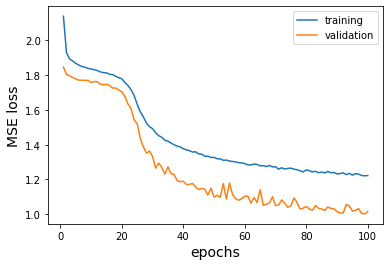

In [18]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

In [19]:
results=myRNN.predict(X_test)

In [20]:
y_test

array([[-1.24140129e+00, -8.88192000e-01,  9.94241735e-01,
        -3.48758960e+00, -2.26321569e+00,  2.46167972e+00],
       [-8.51117036e+00, -1.26717577e+00, -6.36053884e+00,
        -1.91485971e+01, -2.83072612e+00, -1.51046790e+01],
       [-1.36862621e-02, -4.78984242e-02, -2.67514389e-01,
        -4.80987654e-02, -1.49361153e-01, -6.03017945e-01],
       ...,
       [-1.60835268e-01, -1.19740543e-02, -1.07830609e-01,
        -1.10618069e+00, -1.17571043e-01, -7.76054401e-01],
       [-7.25770497e-02, -3.50309500e-02, -2.60381413e-01,
        -3.58773002e+00, -1.45284391e+00, -1.34700448e+01],
       [ 4.17528040e+00, -1.00886561e+00,  2.89703501e+00,
         5.59305105e+00, -1.35187053e+00,  4.07725993e+00]])

In [23]:
(results-y_test)/y_test

array([[ 0.41204707,  0.58094349,  0.37507779, -0.02337146,  0.21841183,
         0.05194956],
       [-0.56747293, -0.43625976, -0.47986848, -0.66950336, -0.54154851,
        -0.6110813 ],
       [ 1.09298498,  0.11684774,  0.93079942,  0.84642937, -0.06236174,
         1.25966563],
       ...,
       [ 3.53251925,  4.77539957,  3.57591692,  0.6798615 ,  0.63707265,
         0.71351295],
       [14.09553344, 11.46632475, 10.55105835, -0.43284465, -0.4594923 ,
        -0.57675777],
       [-0.398921  , -0.41353872, -0.44652154, -0.15028829, -0.1378671 ,
        -0.20613938]])

In [27]:
bjets_DF.iloc[-1]

jet_energy                                               43075.4
jet_flavour                                                    5
secVtx_x                                              0.00417528
secVtx_y                                             -0.00100887
secVtx_z                                              0.00289704
terVtx_x                                              0.00559305
terVtx_y                                             -0.00135187
terVtx_z                                              0.00407726
tracks         [[2.010621651929816e-06, -4.989406079403125e-0...
Name: 99999, dtype: object

In [ ]:
# look at worst perfoming cases and examine the tracks
# look at actual uncertainty on overlap for the vertex
# re-run with minimised errors on tracks see if performance is better

In [152]:
myRNN.predict(np.array([X_test[2]]))

array([[-0.05486715, -0.45196092, -2.455217  , -0.1861686 , -0.99255735,
        -5.3714914 ]], dtype=float32)

couple of things, first the RNN looks like it predicts the same value for all cases. This might be because it uses the null tracks at the end of every single jet and just predicts off of those.
Maybe should consider predicting values that are at least order unity, because mse is gonna be very small otherwise, so convert the vertices into different units (I dunno maybe millimeters or microns)